In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
import kagglehub
from pathlib import Path
from tqdm.auto import tqdm
import wandb

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)

from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# EDA

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

Using device: cpu


In [ ]:
import random
import numpy as np


def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)


SEED = 42
set_seed(SEED)
print(f"Seeds set to {SEED}")


In [47]:
path = Path(kagglehub.dataset_download("alessiocorrado99/animals10")) / "raw-img"

print("Path to dataset files:", path)

Path to dataset files: C:\Users\nikio\.cache\kagglehub\datasets\alessiocorrado99\animals10\versions\2\raw-img


Animals type

In [48]:
clases = os.listdir(path)
print(clases)

['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


Num of photos in each folder

In [ ]:
print(f"{'Class Name':<20} | {'Count'}")
print("-" * 30)
for cl in clases:
    folder_path = path / cl
    count = len(os.listdir(folder_path))
    print(f"{cl:<20} | {count}")

See what we have in dataset

In [ ]:
for cl in clases:
    n=3
    plt.figure(figsize=(12, 8))
    a = path / cl
    imgs = os.listdir(a)
    i=1
    for _ in range(n):
        img_path = a / imgs[_]
        img = Image.open(img_path)

        plt.subplot(4, n, i)
        plt.imshow(img)
        plt.axis("off")
        i += 1

Analyze avg size

In [ ]:
print(f"{'Class':<20} | {'Min W':<6} | {'Max W':<6} | {'Avg W':<8} | {'Min H':<6} | {'Max H':<6} | {'Avg H':<8}")
print("-" * 80)

# Ensure unique classes and sort them
unique_clases = sorted(list(set(clases)))

for cl in unique_clases:
    folder_path = path / cl
    widths = []
    heights = []

    # Skip if not a directory
    if not folder_path.is_dir():
        continue

    # Get all images in the class folder
    try:
        imgs = os.listdir(folder_path)
    except Exception:
        continue

    for im_name in imgs:
        img_path = folder_path / im_name
        try:
            with Image.open(img_path) as im:
                w, h = im.size
                widths.append(w)
                heights.append(h)
        except Exception as e:
            # print(f"Error reading {img_path}: {e}")
            continue

    if widths and heights:
        min_w = min(widths)
        max_w = max(widths)
        avg_w = sum(widths) / len(widths)

        min_h = min(heights)
        max_h = max(heights)
        avg_h = sum(heights) / len(heights)

        print(f"{cl:<20} | {min_w:<6} | {max_w:<6} | {avg_w:<8.1f} | {min_h:<6} | {max_h:<6} | {avg_h:<8.1f}")
    else:
        print(f"{cl:<20} | No images found or error reading images")

In [ ]:
# Analyze Image Channels
modes = {}
channels_count = {}

print("Analyzing image modes and channels")
for cl in clases:
    folder = path / cl
    for img_name in os.listdir(folder):
        img_path = folder / img_name
        try:
            with Image.open(img_path) as img:
                # Count modes (RGB, L, CMYK, etc.)
                modes[img.mode] = modes.get(img.mode, 0) + 1
                # Count channels
                c = len(img.getbands())
                channels_count[c] = channels_count.get(c, 0) + 1
        except:
            pass

print("Image Modes:", modes)
print("Channel Counts:", channels_count)

if 1 in channels_count or 4 in channels_count:
    print("\nNote: Dataset contains images with different channel counts.")
    print("We will convert all images to RGB (3 channels/parameters per pixel) during preprocessing.")
else:
    print("\nAll images are already 3 channels (RGB).")

Analyze if RGB images are truly colorful or grayscale-like

In [ ]:
# Analyze color distribution in images
# Check if RGB images are truly colorful or essentially grayscale

import numpy as np

def analyze_color_info(img):
    """
    Analyze if an image is truly colorful or grayscale-like.
    Returns metrics about color saturation and channel differences.
    """
    img_array = np.array(img.convert("RGB"))

    # Calculate channel-wise statistics
    r, g, b = img_array[:,:,0], img_array[:,:,1], img_array[:,:,2]

    # Check if channels are similar (grayscale-like)
    # If R ≈ G ≈ B for all pixels, image is grayscale
    rg_diff = np.abs(r.astype(float) - g.astype(float)).mean()
    rb_diff = np.abs(r.astype(float) - b.astype(float)).mean()
    gb_diff = np.abs(g.astype(float) - b.astype(float)).mean()

    avg_channel_diff = (rg_diff + rb_diff + gb_diff) / 3

    # Calculate color saturation using HSV-like approach
    max_channel = np.maximum(np.maximum(r, g), b).astype(float)
    min_channel = np.minimum(np.minimum(r, g), b).astype(float)

    # Saturation: difference between max and min channel
    saturation = np.where(max_channel > 0, (max_channel - min_channel) / max_channel, 0)
    avg_saturation = saturation.mean()

    return avg_channel_diff, avg_saturation

print("Analyzing color characteristics per class...")
print(f"{'Class':<20} | {'Colorful':<10} | {'Grayscale-like':<15} | {'Avg Channel Diff':<18} | {'Avg Saturation':<15}")
print("-" * 90)

unique_clases = sorted(list(set(clases)))

for cl in unique_clases:
    folder_path = path / cl

    if not folder_path.is_dir():
        continue

    colorful_count = 0
    grayscale_like_count = 0
    total_channel_diff = 0
    total_saturation = 0
    valid_images = 0

    imgs = os.listdir(folder_path)

    for im_name in imgs:
        img_path = folder_path / im_name
        try:
            with Image.open(img_path) as im:
                channel_diff, saturation = analyze_color_info(im)
                total_channel_diff += channel_diff
                total_saturation += saturation
                valid_images += 1

                # Threshold: if avg channel difference < 5, consider grayscale-like
                if channel_diff < 5:
                    grayscale_like_count += 1
                else:
                    colorful_count += 1
        except Exception:
            continue

    if valid_images > 0:
        avg_diff = total_channel_diff / valid_images
        avg_sat = total_saturation / valid_images
        print(f"{cl:<20} | {colorful_count:<10} | {grayscale_like_count:<15} | {avg_diff:<18.2f} | {avg_sat:<15.4f}")

print("\nNote: Grayscale-like = RGB images where R ≈ G ≈ B (avg channel diff < 5)")
print("Saturation: 0 = no color, 1 = fully saturated")

In [ ]:
files = []
labels = []
class_names = sorted(os.listdir(path))

class_to_idx = {c: i for i, c in enumerate(class_names)}

print("Loading dataset...")
for cl in clases:
    folder = path / cl
    # Verify folder exists
    if not folder.is_dir():
        continue

    for img in os.listdir(folder):
        files.append(str(folder / img))
        labels.append(class_to_idx[cl])

print(f"Total images loaded: {len(files)}")
print(f"Total classes: {len(class_names)}")
print(f"Class mapping: {class_to_idx}")

In [ ]:
print("Splitting dataset into Train / Val / Test sets...")
train_files, temp_files, train_labels, temp_labels = train_test_split(
    files, labels,
    test_size=0.30,
    stratify=labels,
    shuffle=True,
    random_state=42
 )
 
# Split remaining 30% into validation and test (15% / 15%)
val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels,
    test_size=0.50,
    stratify=temp_labels,
    shuffle=True,
    random_state=42
 )
 
print(f"Training samples: {len(train_files)}")
print(f"Validation samples: {len(val_files)}")
print(f"Testing samples: {len(test_files)}")

In [ ]:
#Budeme vyuzivat accuracy a f1

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = 4 if device.type == "cuda" else 0
PIN_MEMORY = device.type == "cuda"

transform = transforms.Compose([
    transforms.Resize((170, 170)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(path, transform=transform)
loader = DataLoader(dataset, batch_size=64, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

sum_ = torch.zeros(3, dtype=torch.double)
sum_sq = torch.zeros(3, dtype=torch.double)
total_pixels = 0

for images, _ in loader:
    b, c, h, w = images.shape
    num_pixels_in_batch = b * h * w

    sum_ += images.sum(dim=[0, 2, 3]).double()
    sum_sq += (images ** 2).sum(dim=[0, 2, 3]).double()
    total_pixels += num_pixels_in_batch

mean_calculated = sum_ / total_pixels
var = (sum_sq / total_pixels) - (mean_calculated ** 2)
std_calculated = torch.sqrt(var)

print("Mean:", mean_calculated.tolist())
print("Std: ", std_calculated.tolist())


C:\Users\nikio\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Mean: [0.517707626799793, 0.5003007536238897, 0.4125557296095215]
Std:  [0.26413124327703913, 0.25914410756442957, 0.27683583555842795]


In [ ]:
# Define training transformations with augmentation
train_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")), # Ensure 3 channels (R, G, B)
    transforms.Resize((170, 170)),                 # Resize to consistent size
    transforms.RandomHorizontalFlip(p=0.5),        # Data Augmentation: Flip
    #transforms.RandomRotation(5),                  # Data Augmentation: Rotate
    transforms.ColorJitter(                        # Data Augmentation: Color
        brightness=0.15,
        contrast=0.15
    ),
    transforms.ToTensor(),                         # Convert to Tensor (0-1 range)
    transforms.Normalize(                          # Normalize to range [-1, 1]
        # mean = [0.517707626799793, 0.5003007536238897, 0.4125557296095215],
        # std = [0.26413124327703913, 0.25914410756442957, 0.27683583555842795]
        mean = mean_calculated.tolist(),
        std = std_calculated.tolist()

    )
])
print("Training transforms defined.")

Training transforms defined.


Visualizing Training Augmentations:


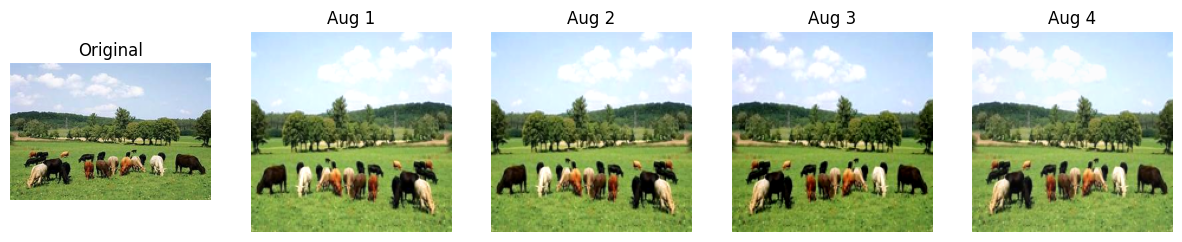

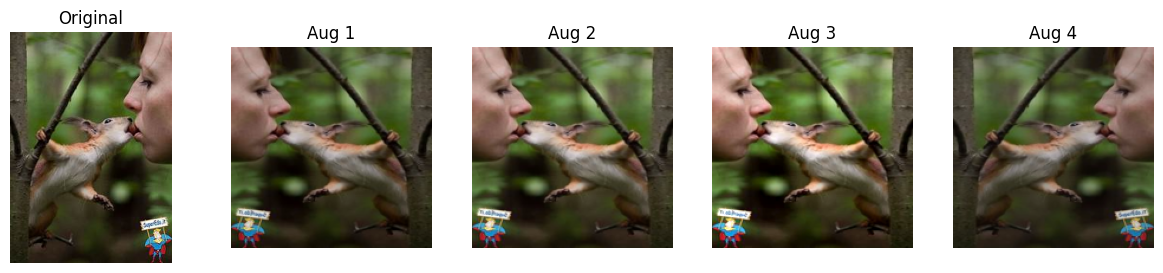

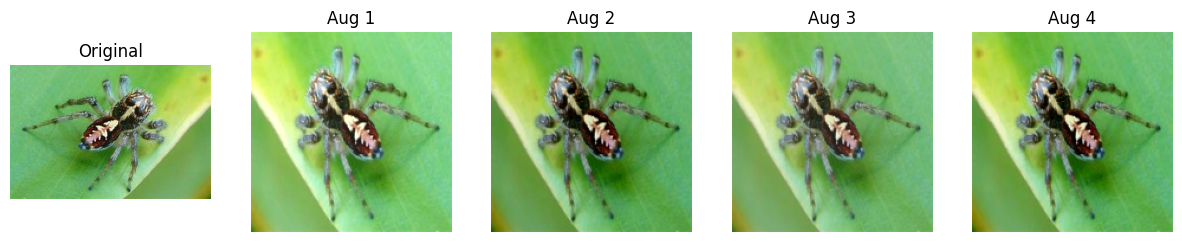

In [ ]:
# Visualization of Augmentations
import numpy as np
import random

def visualize_augmentations(files, transform, n_samples=3):
    """
    Visualizes original images and their augmented versions.
    """
    # Select random files
    sample_files = random.sample(files, n_samples)

    for img_path in sample_files:
        # Load original
        original_img = Image.open(img_path)

        # Apply transform multiple times to see variations
        fig, axes = plt.subplots(1, 5, figsize=(15, 3))

        # Show original
        axes[0].imshow(original_img)
        axes[0].set_title("Original")
        axes[0].axis('off')

        mean = np.array(mean_calculated.tolist())
        std = np.array(std_calculated.tolist())

        for i in range(1, 5):
            # Apply transform
            aug_tensor = transform(original_img)

            # Un-normalize and convert to numpy for display
            aug_img = aug_tensor.permute(1, 2, 0).numpy()
            aug_img = (aug_img * std) + mean
            aug_img = np.clip(aug_img, 0, 1)

            axes[i].imshow(aug_img)
            axes[i].set_title(f"Aug {i}")
            axes[i].axis('off')
        plt.show()

print("Visualizing Training Augmentations:")
visualize_augmentations(train_files, train_transform)


In [ ]:
# Define test transformations (no augmentation)
test_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")), # Ensure 3 channels
    transforms.Resize((170, 170)),                 # Resize to consistent size
    transforms.ToTensor(),                         # Convert to Tensor
    transforms.Normalize(                          # Normalize to range [-1, 1]
        mean_calculated,
        std_calculated
    )
])
print("Test transforms defined.")

Test transforms defined.


In [ ]:
class AnimalDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image, self.labels[idx]

# Initialize Datasets
print("Initializing Datasets...")
train_dataset = AnimalDataset(train_files, train_labels, transform=train_transform)
val_dataset = AnimalDataset(val_files, val_labels, transform=test_transform)
test_dataset = AnimalDataset(test_files, test_labels, transform=test_transform)

# Initialize DataLoaders
BATCH_SIZE = 32
print(f"Initializing DataLoaders with batch size {BATCH_SIZE}...")
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

print("Data preparation complete.")


Initializing Datasets...
Initializing DataLoaders with batch size 32...
Data preparation complete.


Visualizing samples from Test Dataset (Preprocessed)...


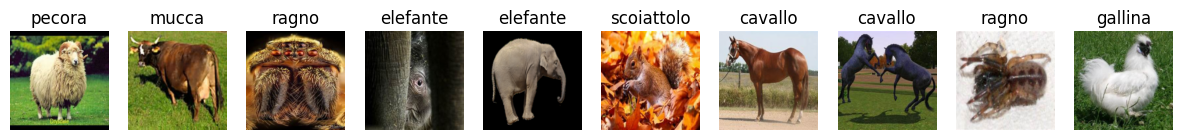

In [ ]:
# Visualize Test Data
print("Visualizing samples from Test Dataset (Preprocessed)...")

def visualize_dataset_samples(dataset, class_names, n_samples=5):
    indices = random.sample(range(len(dataset)), n_samples)

    fig, axes = plt.subplots(1, n_samples, figsize=(15, 3))

    mean = np.array(mean_calculated.tolist())
    std = np.array(std_calculated.tolist())

    for i, idx in enumerate(indices):
        image, label = dataset[idx]

        # Denormalize for visualization
        img_display = image.permute(1, 2, 0).numpy()
        img_display = (img_display * std) + mean
        img_display = np.clip(img_display, 0, 1)

        axes[i].imshow(img_display)
        axes[i].set_title(class_names[label])
        axes[i].axis('off')

    plt.show()

visualize_dataset_samples(test_dataset, class_names, 10)


# CNN Model Architecture

In [ ]:
config = {
    # =============================
    # Dataset and preprocessing
    # =============================
    "data": {
        "num_classes": 10,
        "input_size": (170, 170),
        # "normalize_mean": [0.517707626799793, 0.5003007536238897, 0.4125557296095215],
        # "normalize_std":  [0.26413124327703913, 0.25914410756442957, 0.27683583555842795],
        "normalize_mean": mean_calculated.tolist(),
        "normalize_std": std_calculated.tolist(),
        "class_names": ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
    },

    # =============================
    # Augmentations
    # =============================
    "augmentations": {
        "train": {
            "horizontal_flip": True,
            "vertical_flip": False,
            "color_jitter": True,
        },
        "val": {
            "resize": False,
            "center_crop": True,
        }
    },

    # =============================
    # Model Architecture
    # =============================
    "model": {
        "name": "cnn",

        # Convolution blocks settings
        "conv_blocks": [
            {"out_channels": 32, "kernel": 3, "stride": 1, "padding": 1},
            {"out_channels": 64, "kernel": 3, "stride": 1, "padding": 1},
            {"out_channels": 128, "kernel": 3, "stride": 1, "padding": 1},
        ],

        # Architecture options
        "use_batchnorm": True,
        "use_dropout": True,
        "dropout_rate": 0.3,

        # Residual & bottleneck features
        "use_skip_connections": True,
        "use_bottleneck": False,

        # Fully connected head
        "fc_layers": [256, 64],  # e.g. 128 -> 256 -> 64 -> 10 classes
    },

    # =============================
    # Training
    # =============================
    "train": {
        "batch_size": 32,
        "epochs": 40,
        "learning_rate": 0.001,
        "optimizer": "adam",
        "weight_decay": 1e-4,
        "scheduler": "cosine",
        "num_workers": 4,
        "pin_memory": True,
        "seed": 42,
    },

    # =============================
    # Experiment tracking
    # =============================
    "experiment": {
        "name": "animals_resnet18_baseline",
        "description": "Baseline animal classification with augmentations",
        "save_best_only": True,
        "metric": "accuracy",
    }
}


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, cfg):
        super().__init__()

        k = cfg.get("kernel", 3)
        s = cfg.get("stride", 1)
        p = cfg.get("padding", 1)

        use_bn = cfg.get("use_batchnorm", False)
        use_do = cfg.get("use_dropout", False)
        dr = cfg.get("dropout_rate", 0.3)
        bottleneck = cfg.get("use_bottleneck", False)

        layers = []

        if bottleneck:
            mid = out_ch // 4

            layers += [
                nn.Conv2d(in_ch, mid, kernel_size=1),
                nn.BatchNorm2d(mid) if use_bn else nn.Identity(),
                nn.ReLU(),
                nn.Conv2d(mid, mid, kernel_size=k, stride=s, padding=p),
                nn.BatchNorm2d(mid) if use_bn else nn.Identity(),
                nn.ReLU(),
                nn.Conv2d(mid, out_ch, kernel_size=1),
                nn.BatchNorm2d(out_ch) if use_bn else nn.Identity(),
            ]
        else:

            layers += [
                nn.Conv2d(in_ch, out_ch, kernel_size=k, stride=s, padding=p),
                nn.BatchNorm2d(out_ch) if use_bn else nn.Identity(),
                nn.ReLU(),
            ]

        if use_do:
            layers += [nn.Dropout2d(dr)]

        self.block = nn.Sequential(*layers)

        needs_proj = (in_ch != out_ch) or (s != 1)
        self.proj = (
            nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=s)
            if needs_proj
            else nn.Identity()
        )
        self.use_skip = cfg.get("use_skip_connections", False)

    def forward(self, x):
        out = self.block(x)
        if self.use_skip:
            out += self.proj(x)
        return F.relu(out)
    

class CustomCNN(nn.Module):
    def __init__(self, cfg: dict):
        super().__init__()

        model_cfg = cfg["model"]
        conv_cfgs = model_cfg["conv_blocks"]

        use_bn = model_cfg.get("use_batchnorm", False)
        use_do = model_cfg.get("use_dropout", False)
        dr = model_cfg.get("dropout_rate", 0.3)
        use_skip = model_cfg.get("use_skip_connections", False)
        use_bottleneck = model_cfg.get("use_bottleneck", False)

        fc_layers = model_cfg["fc_layers"]
        num_classes = cfg["data"]["num_classes"]



        conv_blocks = []
        in_ch = 3

        for block in conv_cfgs:
            block_cfg = {
                **block,
                "use_batchnorm": use_bn,
                "use_dropout": use_do,
                "dropout_rate": dr,
                "use_skip_connections": use_skip,
                "use_bottleneck": use_bottleneck,
            }

            conv_blocks.append(ConvBlock(in_ch, block["out_channels"], block_cfg))
            in_ch = block["out_channels"]

        self.conv = nn.Sequential(*conv_blocks)

        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        layers = []
        in_features = in_ch

        for hidden in fc_layers:
            layers += [
                nn.Linear(in_features, hidden),
                nn.ReLU(),
                nn.Dropout(dr) if use_do else nn.Identity(),
            ]
            in_features = hidden

        layers.append(nn.Linear(in_features, num_classes))
        self.fc = nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [51]:
model = CustomCNN(config)
print(model)

CustomCNN(
  (conv): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout2d(p=0.3, inplace=False)
      )
      (proj): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout2d(p=0.3, inplace=False)
      )
      (proj): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (2): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
    

In [ ]:
# Define loss function
criterion = nn.CrossEntropyLoss()
print("Loss function: CrossEntropyLoss")

In [ ]:
# Experiment configurations
base_data_cfg = {
    "num_classes": len(class_names),
    "input_size": (170, 170),
    "normalize_mean": mean_calculated.tolist(),
    "normalize_std": std_calculated.tolist(),
    "class_names": class_names,
}

experiments = {
    "exp1_baseline": {
        "description": "Shallow baseline CNN for quick feedback",
        "model": {
            "conv_blocks": [
                {"out_channels": 32, "kernel": 3, "stride": 1, "padding": 1},
                {"out_channels": 64, "kernel": 3, "stride": 1, "padding": 1},
            ],
            "use_batchnorm": True,
            "use_dropout": True,
            "dropout_rate": 0.2,
            "use_skip_connections": False,
            "use_bottleneck": False,
            "fc_layers": [128],
        },
        "train": {
            "epochs": 6,
            "learning_rate": 1e-3,
            "weight_decay": 1e-4,
            "early_stop_patience": 3,
            "monitor_metric": "accuracy",
        },
    },
    "exp2_deeper": {
        "description": "Deeper CNN with higher capacity",
        "model": {
            "conv_blocks": [
                {"out_channels": 32, "kernel": 3, "stride": 1, "padding": 1},
                {"out_channels": 64, "kernel": 3, "stride": 1, "padding": 1},
                {"out_channels": 128, "kernel": 3, "stride": 1, "padding": 1},
                {"out_channels": 256, "kernel": 3, "stride": 1, "padding": 1},
            ],
            "use_batchnorm": True,
            "use_dropout": True,
            "dropout_rate": 0.3,
            "use_skip_connections": False,
            "use_bottleneck": False,
            "fc_layers": [256, 128],
        },
        "train": {
            "epochs": 8,
            "learning_rate": 8e-4,
            "weight_decay": 1e-4,
            "early_stop_patience": 4,
            "monitor_metric": "accuracy",
        },
    },
    "exp3_skip_dropout": {
        "description": "Skip connections + dropout/batchnorm",
        "model": {
            "conv_blocks": [
                {"out_channels": 32, "kernel": 3, "stride": 1, "padding": 1},
                {"out_channels": 64, "kernel": 3, "stride": 1, "padding": 1},
                {"out_channels": 128, "kernel": 3, "stride": 1, "padding": 1},
                {"out_channels": 128, "kernel": 3, "stride": 1, "padding": 1},
            ],
            "use_batchnorm": True,
            "use_dropout": True,
            "dropout_rate": 0.4,
            "use_skip_connections": True,
            "use_bottleneck": False,
            "fc_layers": [256, 64],
        },
        "train": {
            "epochs": 10,
            "learning_rate": 7e-4,
            "weight_decay": 2e-4,
            "early_stop_patience": 5,
            "monitor_metric": "accuracy",
        },
    },
}
print("Experiment configurations defined (3 setups).")


In [ ]:
# Metrics helpers
def _compute_prf1(labels, preds):
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro", zero_division=0
    )
    return {
        "precision": precision * 100,
        "recall": recall * 100,
        "f1": f1 * 100,
    }


def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    pbar = tqdm(train_loader, desc="Train", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = labels.size(0)
        total_loss += loss.item() * batch_size
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += batch_size
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())
        pbar.set_postfix(loss=loss.item())

    epoch_loss = total_loss / max(total, 1)
    epoch_acc = 100 * correct / max(total, 1)
    metrics = {
        "loss": epoch_loss,
        "accuracy": epoch_acc,
        **_compute_prf1(all_labels, all_preds),
    }
    return metrics


def validate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(data_loader, desc="Val", leave=False)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            batch_size = labels.size(0)
            total_loss += loss.item() * batch_size
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += batch_size
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
            pbar.set_postfix(loss=loss.item())

    epoch_loss = total_loss / max(total, 1)
    epoch_acc = 100 * correct / max(total, 1)
    metrics = {
        "loss": epoch_loss,
        "accuracy": epoch_acc,
        **_compute_prf1(all_labels, all_preds),
    }
    return metrics, all_preds, all_labels

print("Training and validation functions defined with tqdm and metrics.")

In [ ]:
# Experiment runner
def build_model_from_experiment(exp_cfg):
    cfg = {
        "model": exp_cfg["model"],
        "data": base_data_cfg,
    }
    return CustomCNN(cfg).to(device)


def train_and_evaluate(exp_name, exp_cfg, use_wandb=True):
    epochs = exp_cfg["train"]["epochs"]
    lr = exp_cfg["train"]["learning_rate"]
    wd = exp_cfg["train"]["weight_decay"]
    patience = exp_cfg["train"].get("early_stop_patience")
    monitor_metric = exp_cfg["train"].get("monitor_metric", "accuracy")

    model = build_model_from_experiment(exp_cfg)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=2
    )

    history = {"train": [], "val": []}
    best_metric = float("-inf")
    best_model_path = f"best_model_{exp_name}.pth"
    epochs_no_improve = 0

    run = None
    if use_wandb:
        run = wandb.init(
            project="zneus-animal",
            name=exp_name,
            reinit=True,
            config={
                "epochs": epochs,
                "learning_rate": lr,
                "weight_decay": wd,
                "model": exp_cfg["model"],
                "description": exp_cfg.get("description", ""),
                "monitor_metric": monitor_metric,
                "early_stop_patience": patience,
            },
        )

    print(f"\n=== Starting {exp_name} ({exp_cfg.get('description','')}) ===")
    for epoch in range(epochs):
        train_metrics = train_epoch(model, train_loader, criterion, optimizer, device)
        val_metrics, _, _ = validate(model, val_loader, criterion, device)

        scheduler.step(val_metrics["loss"])

        history["train"].append(train_metrics)
        history["val"].append(val_metrics)

        metric_value = val_metrics.get(monitor_metric, float("-inf"))
        improved = metric_value > best_metric
        if improved:
            best_metric = metric_value
            epochs_no_improve = 0
            torch.save(model.state_dict(), best_model_path)
        else:
            epochs_no_improve += 1

        log_payload = {
            "epoch": epoch + 1,
            "train/loss": train_metrics["loss"],
            "train/accuracy": train_metrics["accuracy"],
            "train/precision": train_metrics["precision"],
            "train/recall": train_metrics["recall"],
            "train/f1": train_metrics["f1"],
            "val/loss": val_metrics["loss"],
            "val/accuracy": val_metrics["accuracy"],
            "val/precision": val_metrics["precision"],
            "val/recall": val_metrics["recall"],
            "val/f1": val_metrics["f1"],
            "val/early_stop_metric": metric_value,
        }
        if run:
            run.log(log_payload)

        print(
            f"Epoch [{epoch+1}/{epochs}] | "
            f"Train Loss: {train_metrics['loss']:.4f} | Train Acc: {train_metrics['accuracy']:.2f}% | "
            f"Val Loss: {val_metrics['loss']:.4f} | Val Acc: {val_metrics['accuracy']:.2f}% | "
            f"Val F1: {val_metrics['f1']:.2f}%"
        )

        if patience is not None and epochs_no_improve >= patience:
            print(
                f"Early stopping triggered after {epoch+1} epochs (no {monitor_metric} improvement for {patience} epochs)."
            )
            if run:
                run.log({"early_stopped_epoch": epoch + 1})
            break

    # Reload best model and evaluate on test
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    model.to(device)

    test_metrics, test_preds, test_labels = validate(model, test_loader, criterion, device)

    if run:
        run.log({
            "test/loss": test_metrics["loss"],
            "test/accuracy": test_metrics["accuracy"],
            "test/precision": test_metrics["precision"],
            "test/recall": test_metrics["recall"],
            "test/f1": test_metrics["f1"],
            "best_val_metric": best_metric,
        })
        try:
            run.log({
                "test/confusion_matrix": wandb.plot.confusion_matrix(
                    preds=test_preds,
                    y_true=test_labels,
                    class_names=class_names,
                )
            })
        except Exception:
            pass
        run.finish()

    print(
        f"\n>>> {exp_name} done | Best Val {monitor_metric}: {best_metric:.2f} | "
        f"Test Acc: {test_metrics['accuracy']:.2f}% | Test F1: {test_metrics['f1']:.2f}%"
    )

    return {
        "history": history,
        "best_val_metric": best_metric,
        "test_metrics": test_metrics,
        "test_preds": test_preds,
        "test_labels": test_labels,
        "best_model_path": best_model_path,
    }

# Run experiments
use_wandb = True
experiment_results = {}
for exp_name, exp_cfg in experiments.items():
    experiment_results[exp_name] = train_and_evaluate(exp_name, exp_cfg, use_wandb=use_wandb)
print("All experiments completed.")


In [ ]:
# Plot training history across experiments
metrics_to_plot = ["loss", "accuracy", "f1"]
for metric in metrics_to_plot:
    plt.figure(figsize=(8, 5))
    for exp_name, res in experiment_results.items():
        train_curve = [m[metric] for m in res["history"]["train"]]
        val_curve = [m[metric] for m in res["history"]["val"]]
        epochs_range = range(1, len(train_curve) + 1)
        plt.plot(epochs_range, train_curve, label=f"{exp_name} train")
        plt.plot(epochs_range, val_curve, linestyle='--', label=f"{exp_name} val")
    plt.xlabel('Epoch')
    ylabel = 'Value' if metric == 'loss' else f"{metric.capitalize()} (%)"
    plt.ylabel(ylabel)
    plt.title(f"{metric.capitalize()} curves")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Tabular summary of test metrics
rows = []
for exp_name, res in experiment_results.items():
    tm = res["test_metrics"]
    rows.append({
        "experiment": exp_name,
        "test_loss": tm["loss"],
        "test_acc": tm["accuracy"],
        "test_precision": tm["precision"],
        "test_recall": tm["recall"],
        "test_f1": tm["f1"],
        "best_val_acc": res["best_val_acc"],
    })
summary_df = pd.DataFrame(rows)
display(summary_df.sort_values(by="test_f1", ascending=False).reset_index(drop=True))

In [ ]:
# Confusion matrices per experiment
import seaborn as sns

for exp_name, res in experiment_results.items():
    preds = res["test_preds"]
    labels = res["test_labels"]
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {exp_name}')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()